# Customer Segmentation using Clustering
Tamara Monge
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
import seaborn as sns
from sklearn.cluster import KMeans

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

/Users/tami/anaconda/lib/python3.6/site-packages/pandas/util/_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

/Users/tami/anaconda/lib/python3.6/site-packages/pandas/util/_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
#your turn
df_customers = pd.merge_ordered(df_transactions, df_offers, how='outer', on='offer_id')
df = pd.pivot_table(df_customers, values='n', index='customer_name', columns='offer_id', aggfunc='count', fill_value=0)
df.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

<div class="alert alert-warning" role="alert">
<b>Answer:</b> Smaller values of $SS$ mean better clusterings. The smaller the $SS$, the closer the data points are to their respective centroids. 
</div>

In [5]:
x_cols = np.matrix(df[1:])

In [6]:
kmeans = KMeans()
clusters_pred = kmeans.fit_transform(x_cols)

In [7]:
ks = range(2,11)
ss = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(x_cols)
    ss.append(kmeans.inertia_)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

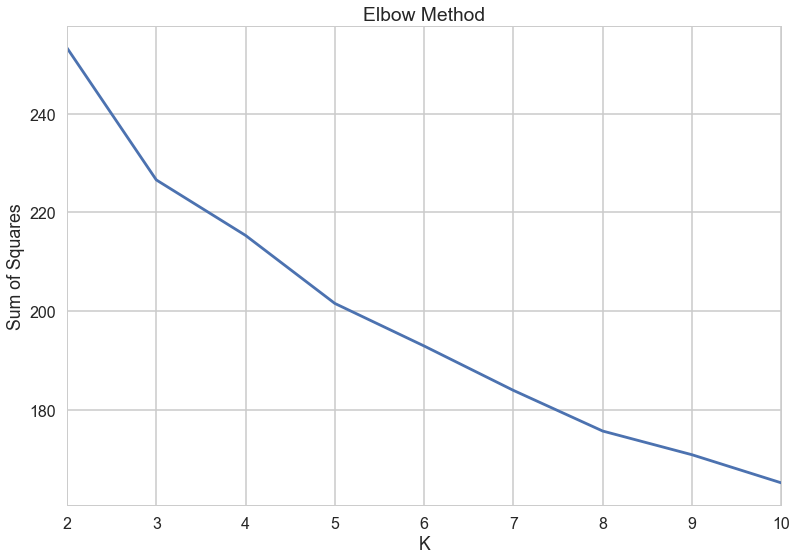

In [8]:
_ = plt.plot(ks, ss)
_ = plt.xlim([2,10])
_ = plt.xlabel('K')
_ = plt.ylabel('Sum of Squares')
_ = plt.title('Elbow Method')

In [9]:
# best k = 3
cluster_pred = KMeans(n_clusters=3, random_state=1).fit_predict(x_cols)

0    48
1    36
2    15
dtype: int64

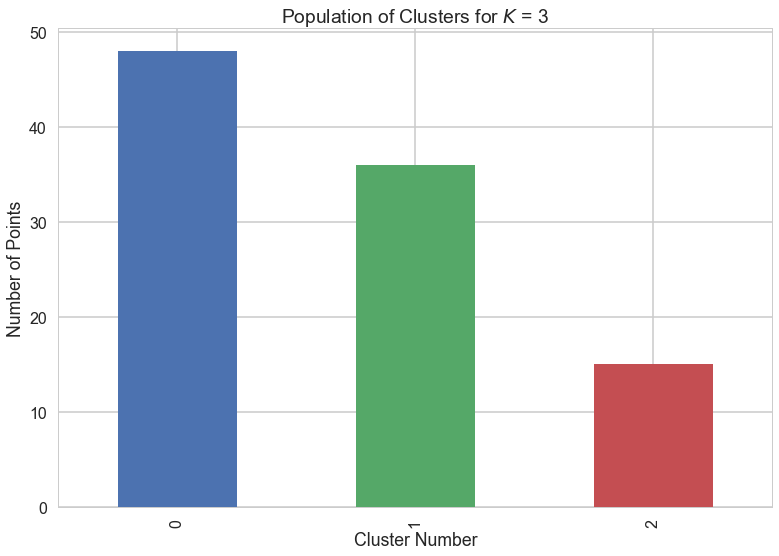

In [10]:
cluster_population = pd.Series(cluster_pred).value_counts().sort_index()
cluster_population

_ = cluster_population.plot(kind='bar')
_ = plt.ylabel('Number of Points')
_ = plt.xlabel('Cluster Number')
_ = plt.title('Population of Clusters for $K$ = 3')

<div class="alert alert-warning" role="alert">
<b>Answer:</b> The Elbow Method was challenging because the figure doesn't display one clear elbow. It seems one could choose $K$ = 3, 5, or 8. 
</div>

<div class="span5 alert warning-info">

</div>

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.0893635891515
For n_clusters = 3 The average silhouette_score is : 0.119643653202
For n_clusters = 4 The average silhouette_score is : 0.123232225963
For n_clusters = 5 The average silhouette_score is : 0.0872350357841
For n_clusters = 6 The average silhouette_score is : 0.13080575578
For n_clusters = 7 The average silhouette_score is : 0.113979234152
For n_clusters = 8 The average silhouette_score is : 0.114701006188
For n_clusters = 9 The average silhouette_score is : 0.104085835739
For n_clusters = 10 The average silhouette_score is : 0.136917097977


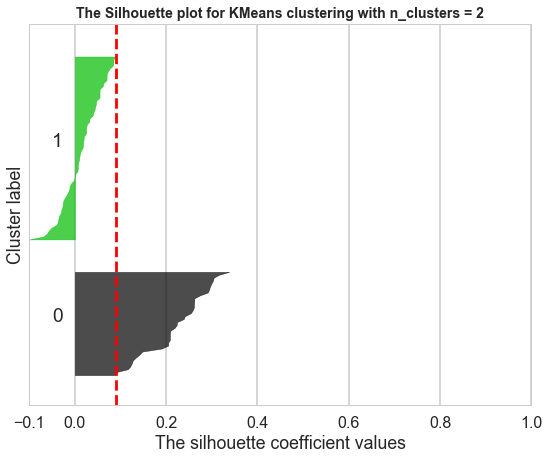

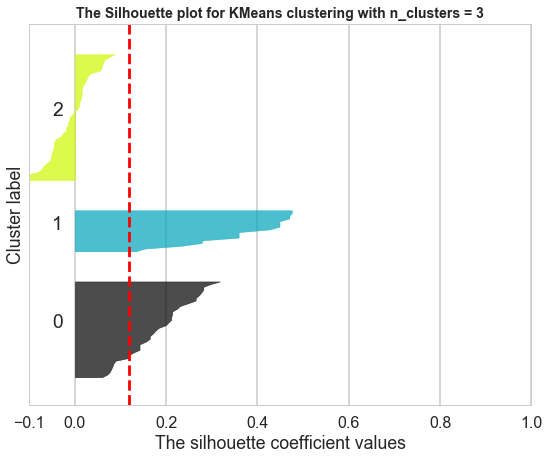

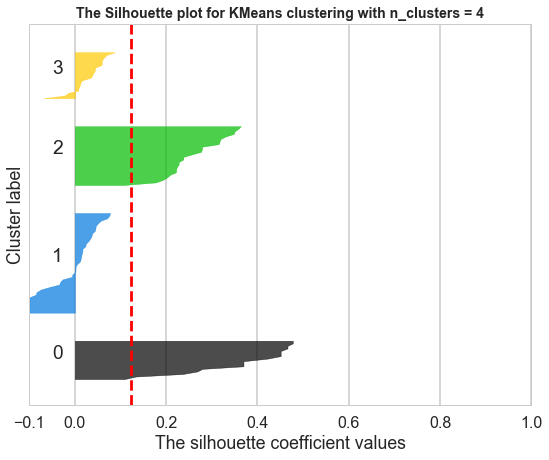

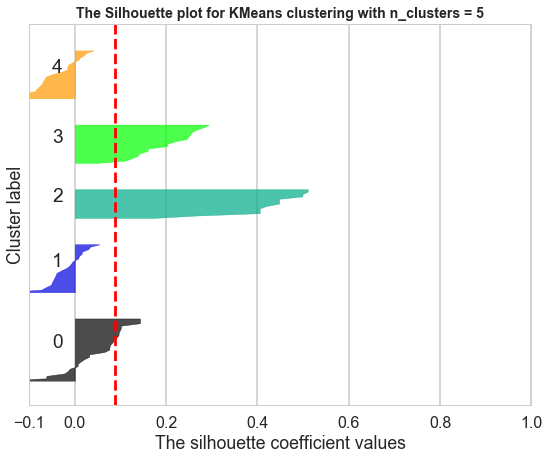

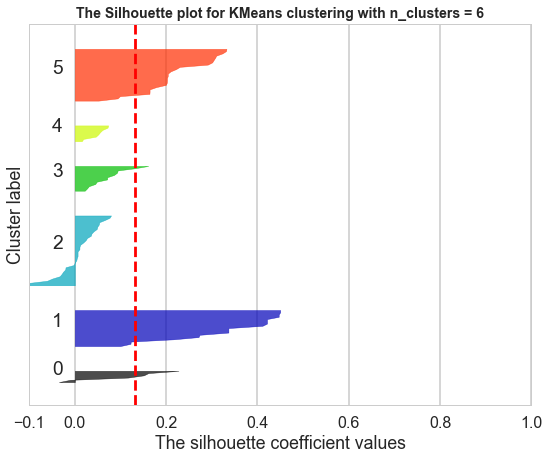

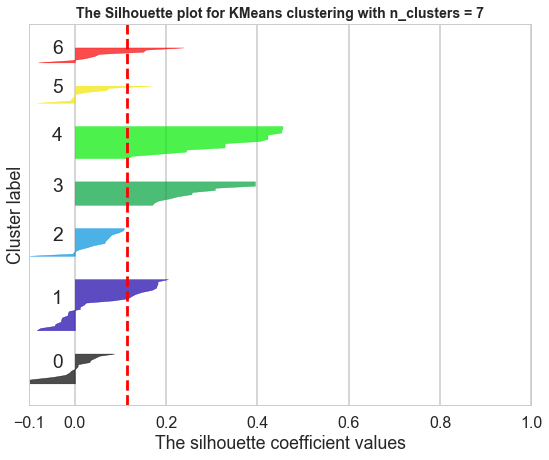

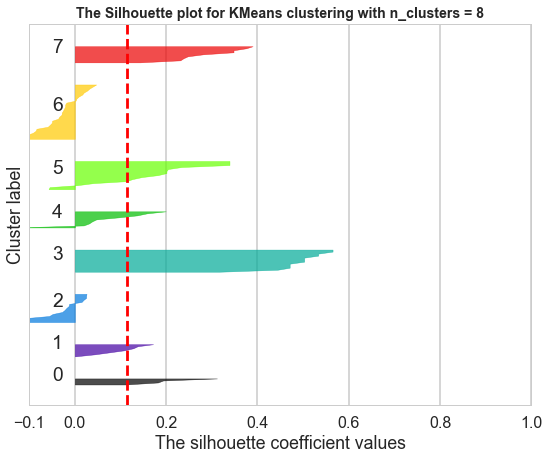

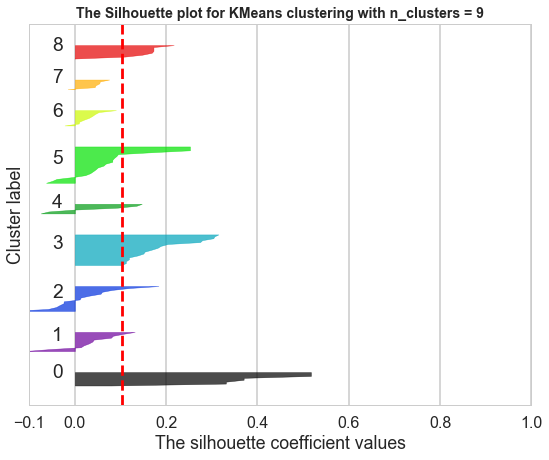

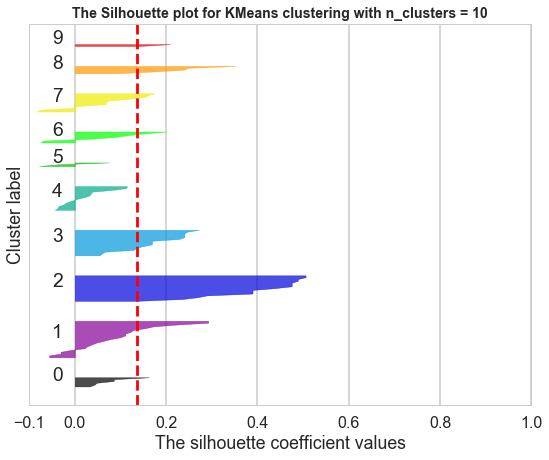

In [11]:
# Your turn.
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm


range_n_clusters = range(2,11)
silhouette_avgscores = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    _ = fig.set_size_inches(9, 7)

    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    _ = ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    _ = ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    silhouette_avgscores.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        _ = ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        _ = ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    _ = ax1.set_title(("The Silhouette plot for KMeans clustering with n_clusters = %d" % n_clusters), fontsize=14, fontweight='bold')
    _ = ax1.set_xlabel("The silhouette coefficient values")
    _ = ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    _ = ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    _ = ax1.set_yticks([])  # Clear the yaxis labels / ticks
    _ = ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


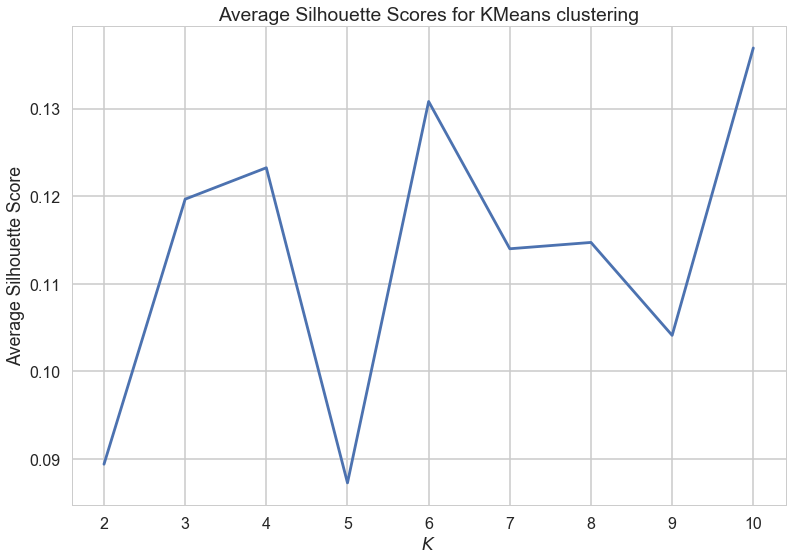

In [12]:
_ = plt.plot(range_n_clusters,silhouette_avgscores)
_ = plt.xlabel('$K$')
_ = plt.ylabel('Average Silhouette Score')
_ = plt.title('Average Silhouette Scores for KMeans clustering')

<div class="alert alert-warning" role="alert">
<b>Answer:</b> The Silhouette Method suggests we should use $K$ = 10. This is different from the Elbow Method. (Actually, since 10 is at the edge of our test-value range, we should expand our test range.)  
</div>

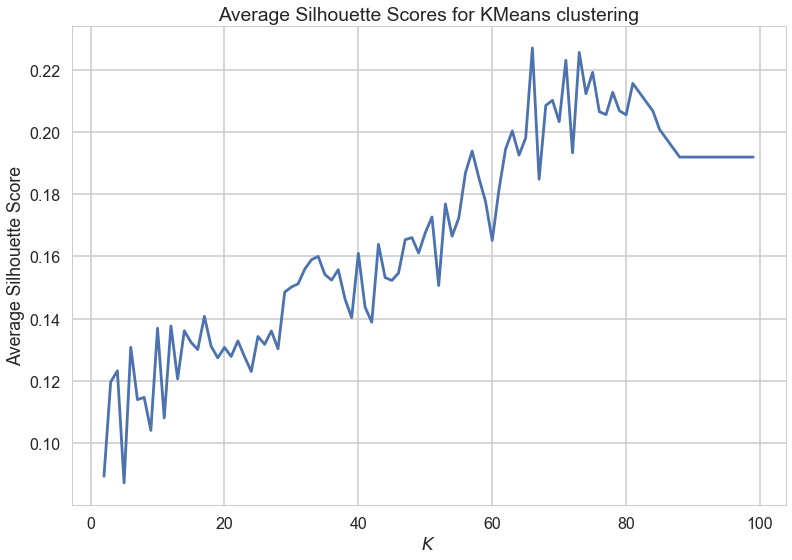

In [13]:
range_n_clusters = range(2,100)
silhouette_avgscores= []

for n_clusters in range_n_clusters:
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    silhouette_avgscores.append(silhouette_avg)
#     print("For n_clusters =", n_clusters,
#           "The average silhouette_score is :", silhouette_avg)

_ = plt.plot(range(2,100),silhouette_avgscores)
_ = plt.xlabel('$K$')
_ = plt.ylabel('Average Silhouette Score')
_ = plt.title('Average Silhouette Scores for KMeans clustering')    

In [14]:
np.max(silhouette_avgscores)
np.argmax(silhouette_avgscores)

0.22697753095406992

64

<div class = "alert alert-warning" role="alert">
<b>Answer: </b> Having expanded our range of $K$s, we find the Silhouette Method gives a best value of $K$ = 64. This seems a **very** large number of clusters. 
</div>

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [15]:
#your turn
# Initialize pca with 2 components
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

# Begin building dataframe
df_pca = pd.DataFrame(np.array(df.index))

# Initialize clusterer using 3 clusters, fit and predict on x_cols 
clusterer = KMeans(n_clusters=3, random_state=10)
clusterer.fit_predict(x_cols)

# Continue building dataframe
df_pca['cluster_label'] = pd.DataFrame(clusterer.fit_predict(x_cols)) 
df_pca['x'] = pd.DataFrame(pca.fit_transform(x_cols)).iloc[:,0]
df_pca['y'] = pd.DataFrame(pca.fit_transform(x_cols)).iloc[:,1]
df_pca.columns = ['customer_name', 'cluster_label', 'x', 'y']
df_pca

array([2, 1, 0, 0, 2, 1, 0, 2, 0, 2, 1, 0, 2, 2, 1, 2, 1, 0, 2, 0, 0, 2, 2,
       1, 2, 2, 2, 2, 1, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 1, 1, 0, 2, 0, 2, 0,
       0, 2, 2, 2, 2, 2, 1, 0, 0, 1, 0, 0, 2, 2, 0, 2, 0, 0, 1, 1, 2, 2, 2,
       2, 2, 2, 0, 2, 0, 1, 0, 0, 1, 2, 2, 2, 1, 0, 0, 0, 2, 2, 0, 2, 0, 2,
       0, 2, 2, 0, 2, 2, 2], dtype=int32)

,customer_name,cluster_label,x,y
0,Adams,2.0,-0.277613,0.042729
1,Allen,1.0,-0.388263,1.036354
2,Anderson,0.0,0.714345,-0.012917
3,Bailey,0.0,0.131082,-0.463859
4,Baker,2.0,-0.462860,-0.728535
5,Barnes,1.0,-0.592077,1.502465
6,Bell,0.0,0.677273,0.100310
7,Bennett,2.0,-0.081068,-0.573659
8,Brooks,0.0,1.078833,0.003631
9,Brown,2.0,-0.247684,-0.623738


In [16]:
#set style of plots
sns.set(style='white', palette='muted')

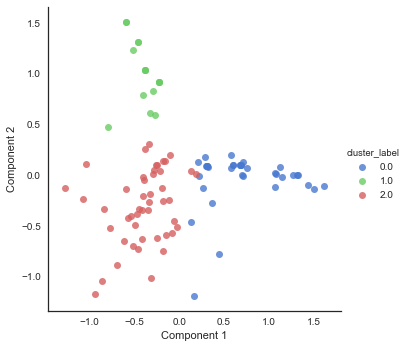

In [17]:
#plot data with seaborn
ax = sns.lmplot(data=df_pca, x='x', y='y', hue='cluster_label', 
                   fit_reg=False, legend=True, legend_out=True)
_ = ax.set_axis_labels("Component 1", "Component 2")

# _ = plt.scatter(df_pca['x'], df_pca['y'], c=df_pca['cluster_label'], edgecolors='k')
# _ = plt.xlabel('Component 1')
# _ = plt.ylabel('Component 2')
# _ = plt.title('PCA Components')

<div class="alert alert-warning" role="alert">
<b>Answer:</b> Based on the PCA figure, $K$ = 3 is the best choice. The method that most clearly produced this optimal $K$ was the Elbow Method. 
</div>

In [18]:
df_new = pd.merge_ordered(df_customers, df_pca, how='outer', on='customer_name')

In [19]:
#add new column: ['is_red']
red_dict = {'Champagne':0, 'Pinot Noir':1, 'Prosecco':0, 'Espumante':0, 'Cabernet Sauvignon':1, 'Malbec':1, 'Merlot':1, 'Pinot Grigio':0, 'Chardonnay':0}
df_new['is_red'] = df_new['varietal']
df_new.replace({'is_red':red_dict}, inplace=True)

#add new column: ['continent']
continent_dict = {'France':0, 'Australia':1, 'Chile':2, 'Oregon':3, 'South Africa':4, 'Italy':0, 'Germany':0, 'California':3, 'New Zealand':1}
df_new['continent'] = df_new['origin']
df_new.replace({'continent':continent_dict}, inplace=True)

In [20]:
df_new.groupby(['cluster_label']).varietal.value_counts()
df_new.groupby('cluster_label').campaign.value_counts()
df_new.groupby('cluster_label').origin.value_counts()
df_new.groupby('cluster_label').is_red.value_counts()
df_new.groupby('cluster_label').continent.value_counts()
df_new.groupby("cluster_label")[['is_red','min_qty', 'discount', 'past_peak']].mean()

cluster_label  varietal          
0.0            Champagne             33
               Pinot Noir            27
               Prosecco              18
               Espumante             14
               Cabernet Sauvignon     7
               Malbec                 7
               Merlot                 4
               Pinot Grigio           4
               Chardonnay             1
1.0            Champagne             14
               Malbec                 9
               Espumante              6
               Pinot Noir             6
               Prosecco               5
               Cabernet Sauvignon     4
               Chardonnay             4
               Merlot                 3
               Pinot Grigio           3
2.0            Champagne             32
               Espumante             20
               Cabernet Sauvignon    19
               Prosecco              19
               Malbec                16
               Merlot                13
      

cluster_label  campaign 
0.0            March        21
               December     14
               August       13
               October      13
               July         12
               May           9
               February      8
               September     8
               January       7
               November      5
               June          4
               April         1
1.0            December      9
               January       7
               August        6
               March         6
               November      5
               April         4
               October       4
               July          3
               May           3
               September     3
               February      2
               June          2
2.0            March        23
               December     18
               June         13
               November     13
               October      13
               February     12
               May          12
              

cluster_label  origin      
0.0            France          43
               Australia       20
               Italy           11
               Germany         10
               Oregon           9
               Chile            8
               South Africa     7
               California       4
               New Zealand      3
1.0            France          27
               California       5
               Chile            5
               South Africa     5
               Australia        4
               Oregon           3
               Italy            2
               New Zealand      2
               Germany          1
2.0            France          56
               Chile           22
               Australia       15
               Oregon          14
               South Africa    13
               Italy           10
               New Zealand      8
               California       7
               Germany          4
Name: origin, dtype: int64

cluster_label  is_red
0.0            0         70
               1         45
1.0            0         32
               1         22
2.0            0         90
               1         59
Name: is_red, dtype: int64

cluster_label  continent
0.0            0            64
               1            23
               3            13
               2             8
               4             7
1.0            0            30
               3             8
               1             6
               2             5
               4             5
2.0            0            70
               1            23
               2            22
               3            21
               4            13
Name: continent, dtype: int64

,is_red,min_qty,discount,past_peak
cluster_label,,,,
0.0,0.391304,57.547826,59.921739,0.173913
1.0,0.407407,54.888889,58.981481,0.129630
2.0,0.395973,58.348993,59.308725,0.194631


<div class="alert alert-warning" role="alert">
<b>Answer:</b>
Quantitatively, we can see the following patterns in the different customer groups:

<br>- March campaigns are most successful with customers in Groups 0 and 2. Perhaps customers in these groups are more inclinced to celebrate St. Patrick's Day. 

<br>- Across all groups, the white varieties are the biggest sellers. With that said, customers in Group 1 are slightly more inclined to purchase red varieties than other groups. 

<br>- Across all groups, European wines are the biggest sellers. Chilean wines are mostly purchased by Group 2. Australian wines are mostly purchased by Groups 0 and 2. 

<br>- The customers in Group 1 like to buy in smaller quantities, those in Group 2 like to buy in larger quantities, and those in Group 0 fall in between. 

<br>- The customers in Group 2 are the most willing to buy wine that is past its peak and those in Group 1 are least likely to do so. 

<br>Let's now see if we can determine any patterns visually.
</div>

In [21]:
#convert ['campiagn'] to numerical
campaign_dict = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9,'October':10, 'November':11, 'December':12}
df_new.replace({'campaign':campaign_dict}, inplace=True)

#convert ['varietal'] to numerical
df_new['varietal'].value_counts()
varietal_dict = {'Champagne':1, 'Pinot Noir':2, 'Prosecco':3, 'Espumante':4, 'Cabernet Sauvignon':5, 'Malbec':6, 'Merlot':7, 'Pinot Grigio':8, 'Chardonnay':9}
df_new.replace({'varietal':varietal_dict}, inplace=True)

#convert ['origin'] to numerical
df_new['origin'].value_counts()
origin_dict = {'France':0, 'Australia':1, 'Chile':2, 'Oregon':3, 'South Africa':4, 'Italy':5, 'Germany':6, 'California':7, 'New Zealand':8}
df_new.replace({'origin':origin_dict}, inplace=True)

Champagne             81
Pinot Noir            44
Prosecco              43
Espumante             40
Malbec                32
Cabernet Sauvignon    32
Merlot                20
Pinot Grigio          17
Chardonnay            15
Name: varietal, dtype: int64

France          128
Australia        39
Chile            37
Oregon           26
South Africa     25
Italy            24
California       16
Germany          16
New Zealand      13
Name: origin, dtype: int64

In [22]:
df_new.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            314, 315, 316, 317, 318, 319, 320, 321, 322, 323],
           dtype='int64', length=324)

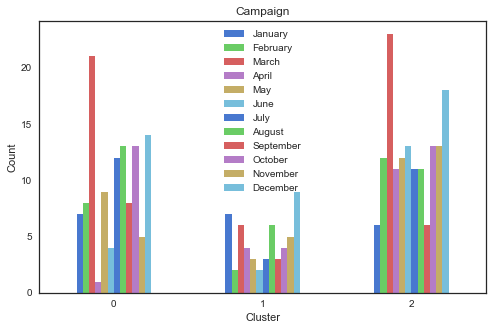

In [23]:
_ = pd.crosstab(df_new['cluster_label'], df_new['campaign']).plot(kind='bar', figsize=(8,5))
_ = plt.title('Campaign')
_ = plt.xlabel('Cluster')
_ = plt.xticks(range(0,3), ('0', '1', '2'), rotation=0) 
_ = plt.ylabel('Count')
_ = plt.legend(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November','December'])

<div class="alert alert-warning" role="alert">
<b>Answer:</b> This plot shows that Groups 0 and 2 purchase the most during the March campaign. Group 1 seems to prefer the December campaign. The December campaign is also popular with Groups 0 and 2. The April campaign was very unpopular with Group 0. </div>

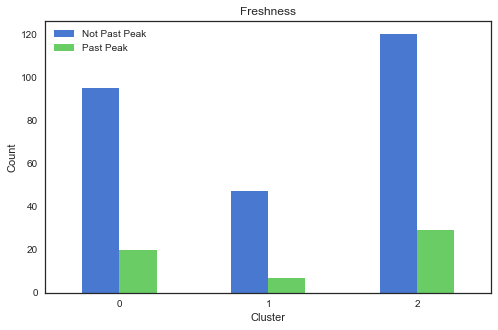

In [24]:
_ = pd.crosstab(df_new['cluster_label'], df_new['past_peak']).plot(kind='bar', figsize=(8,5))
_ = plt.title('Freshness')
_ = plt.xlabel('Cluster')
_ = plt.xticks(range(0,3), ('0', '1', '2'), rotation=0) 
_ = plt.ylabel('Count')
_ = plt.legend(['Not Past Peak', 'Past Peak']) 


<div class="alert alert-warning" role="alert">
<b>Answer:</b> This plot shows that all three customer groups purchase more fresh wine than wine past its peak. </div>

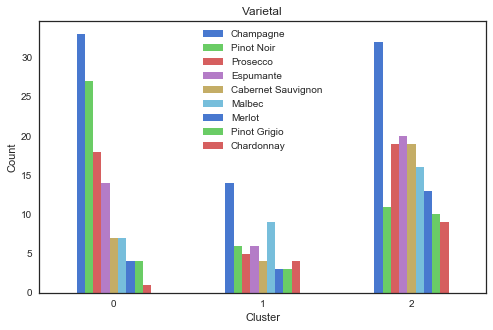

In [25]:
_ = pd.crosstab(df_new['cluster_label'], df_new['varietal']).plot(kind='bar', figsize=(8,5))
_ = plt.title('Varietal')
_ = plt.xlabel('Cluster')
_ = plt.xticks(range(0,3), ('0', '1', '2'), rotation=0) 
_ = plt.ylabel('Count')
_ = plt.legend(['Champagne', 'Pinot Noir', 'Prosecco', 'Espumante', 'Cabernet Sauvignon', 'Malbec', 'Merlot', 'Pinot Grigio', 'Chardonnay'])

<div class="alert alert-warning" role="alert">
<b>Answer:</b> This plot shows that champagne is by far the most popular variety across all three groups. Group 0 also repsonds well to pinot noir promotions but does not purchase much chardonnay. </div>

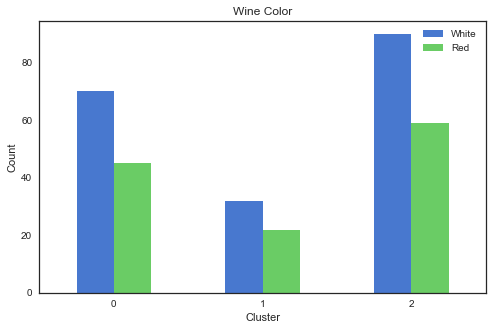

In [26]:
_ = pd.crosstab(df_new['cluster_label'], df_new['is_red']).plot(kind='bar', figsize=(8,5))
_ = plt.title('Wine Color')
_ = plt.xlabel('Cluster')
_ = plt.xticks(range(0,3), ('0', '1', '2'), rotation=0) 
_ = plt.ylabel('Count')
_ = plt.legend(['White', 'Red'])

<div class="alert alert-warning" role="alert">
<b>Answer:</b> This plot shows that all three customer groups purchase more white wine than red (where we've included Champagne in the "white" class).  </div>

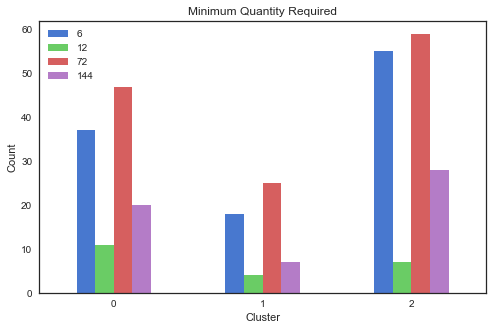

In [27]:
_ = pd.crosstab(df_new['cluster_label'], df_new['min_qty']).plot(kind='bar', figsize=(8,5))
_ = plt.title('Minimum Quantity Required')
_ = plt.xlabel('Cluster')
_ = plt.xticks(range(0,3), ('0', '1', '2'), rotation=0) 
_ = plt.ylabel('Count')
_ = plt.legend(['6', '12', '72', '144'])

<div class="alert alert-warning" role="alert">
<b>Answer:</b> This plot shows that there is not much discernable difference in minimum quantity between the groups. </div>

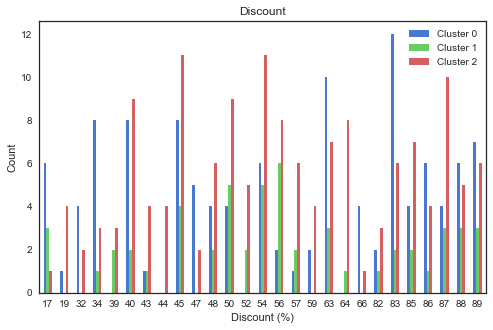

In [28]:
_ = pd.crosstab(df_new['discount'], df_new['cluster_label']).plot(kind='bar', figsize=(8,5))
_ = plt.title('Discount')
_ = plt.xlabel('Discount (%)')
_ = plt.xticks(rotation=0) 
_ = plt.ylabel('Count')
_ = plt.legend(['Cluster 0', 'Cluster 1', 'Cluster 2'])

<div class="alert alert-warning" role="alert">
<b>Answer:</b> This plot shows that there is a wide range of responses amongst the groups when it comes to the discount of the campaign. </div>

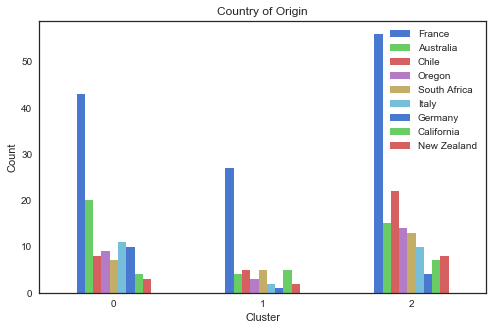

In [29]:
_ = pd.crosstab(df_new['cluster_label'], df_new['origin']).plot(kind='bar', figsize=(8,5))
_ = plt.title('Country of Origin')
_ = plt.xlabel('Cluster')
_ = plt.xticks(range(0,3), ('0', '1', '2'), rotation=0) 
_ = plt.ylabel('Count')
_ = plt.legend(['France', 'Australia', 'Chile', 'Oregon', 'South Africa', 'Italy', 'Germany', 'California', 'New Zealand'])

<div class="alert alert-warning" role="alert">
<b>Answer:</b> This plot shows that all three customer groups purchase a lot of French wine. Group 0 also likes Australian wine, while group 2 also likes Chilean wine. </div>

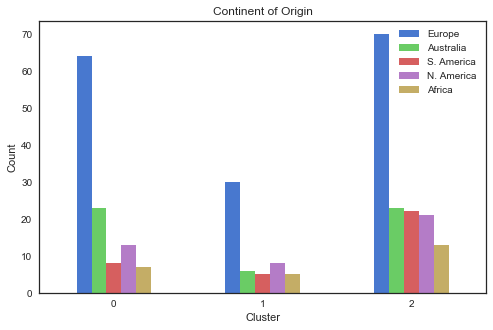

In [30]:
_ = pd.crosstab(df_new['cluster_label'], df_new['continent']).plot(kind='bar', figsize=(8,5))
_ = plt.title('Continent of Origin')
_ = plt.xlabel('Cluster')
_ = plt.xticks(range(0,3), ('0', '1', '2'), rotation=0) 
_ = plt.ylabel('Count')
_ = plt.legend(['Europe', 'Australia', 'S. America', 'N. America', 'Africa'])

<div class="alert alert-warning" role="alert">
<b>Answer:</b> This plot shows that while every group buys wine from Europe, Groups 0 also likes Australian wine, and Group 3 likes Australian, South American, and North American wines almost equally. </div>

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

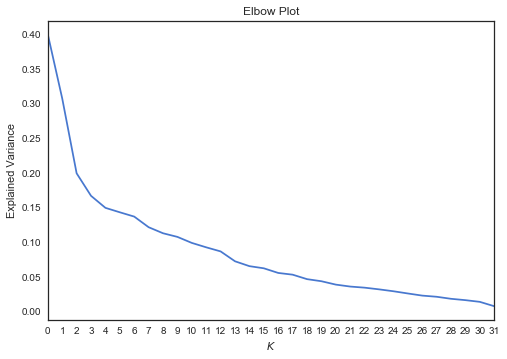

In [31]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)
_ = plt.plot(pca.explained_variance_)
_ = plt.xlabel('$K$')
_ = plt.xticks(range(0,33,1))
_ = plt.xlim([0,31])
_ = plt.ylabel('Explained Variance')
_ = plt.title('Elbow Plot')

<div class="alert alert-warning" role="alert">
<b>Answer:</b> Based on this figure, I would say the optimal number of dimensions is 2 or 4.
</div>

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [32]:
# Your turn
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN
algorithms = ['AffinityPropagation', 'SpectralClustering', 'AgglomerativeClustering', 'DBSCAN']
algorithm_silscores = pd.Series(index=algorithms)

In [33]:
#Affinity Propagation

#find the best value for damping parameter. 
dampings = [0.5, 0.6, 0.7, 0.8, 0.9]
best_score = 0.0
for damping in dampings:
    ap = AffinityPropagation(damping=damping)
    labels = ap.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, labels, random_state=10)
    print("For damping =", damping,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_damping = damping
        
print('Best damping parameter:', best_damping)
algorithm_silscores.loc['AffinityPropagation'] = best_score

For damping = 0.5 The average silhouette_score is : 0.130021465267
For damping = 0.6 The average silhouette_score is : 0.110838053843
For damping = 0.7 The average silhouette_score is : 0.110838053843
For damping = 0.8 The average silhouette_score is : 0.110838053843
For damping = 0.9 The average silhouette_score is : 0.121141802069
Best damping parameter: 0.5


In [34]:
#Spectral Clustering

#find the best value for n_clusters parameter. 
range_n_clusters = range(2,11)
best_score = 0.0
for n_clusters in range_n_clusters:
    sc = SpectralClustering(n_clusters=n_clusters)
    labels = sc.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, labels, random_state=10)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters
        
print('Best n_clusters parameter:',best_n_clusters)
algorithm_silscores.loc['SpectralClustering'] = best_score 

For n_clusters = 2 The average silhouette_score is : 0.0585621111429
For n_clusters = 3 The average silhouette_score is : 0.101511991202
For n_clusters = 4 The average silhouette_score is : 0.0292532109158
For n_clusters = 5 The average silhouette_score is : -0.0150736142303
For n_clusters = 6 The average silhouette_score is : 0.00403425102821
For n_clusters = 7 The average silhouette_score is : 0.0534400571945
For n_clusters = 8 The average silhouette_score is : 0.0525838642169
For n_clusters = 9 The average silhouette_score is : 0.0380136236503
For n_clusters = 10 The average silhouette_score is : 0.0250165533782
Best n_clusters parameter: 3


In [35]:
#Agglomerative Clustering

#find the best value for n_clusters parameter. 
range_n_clusters = range(2,11)
best_score = 0.0
for n_clusters in range_n_clusters:
    ac = AgglomerativeClustering(n_clusters=n_clusters)
    labels = ac.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, labels, random_state=10)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters
        
print('Best n_clusters parameter:',best_n_clusters)
algorithm_silscores.loc['AgglomerativeClustering'] = best_score

For n_clusters = 2 The average silhouette_score is : 0.0790946165527
For n_clusters = 3 The average silhouette_score is : 0.113691265383
For n_clusters = 4 The average silhouette_score is : 0.126560434072
For n_clusters = 5 The average silhouette_score is : 0.138690208203
For n_clusters = 6 The average silhouette_score is : 0.108255121233
For n_clusters = 7 The average silhouette_score is : 0.116312338979
For n_clusters = 8 The average silhouette_score is : 0.123989908234
For n_clusters = 9 The average silhouette_score is : 0.13251611762
For n_clusters = 10 The average silhouette_score is : 0.132094486599
Best n_clusters parameter: 5


In [36]:
#DBSCAN

#find the best value for min_samples parameter. 
range_min_samples = [1, 2, 3]
best_score = 0.0
for min_samples in range_min_samples:
    db = DBSCAN(min_samples=min_samples)
    labels = db.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, labels, random_state=10)
    print("For min_samples =", min_samples,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_min_samples = min_samples
        
print('Best min_samples parameter:',best_min_samples)
algorithm_silscores.loc['DBSCAN'] = best_score

For min_samples = 1 The average silhouette_score is : 0.191919191919
For min_samples = 2 The average silhouette_score is : -0.0165799514077
For min_samples = 3 The average silhouette_score is : -0.107208110729
Best min_samples parameter: 1


In [37]:
print(algorithm_silscores)

AffinityPropagation        0.130021
SpectralClustering         0.101512
AgglomerativeClustering    0.138690
DBSCAN                     0.191919
dtype: float64


<div class="alert alert-warning" role="alert">
<b>Answer:</b> None of the clustering models performed very well. Each model had a silhouette score < 0.2, meaning "No substantial structure was found." This makes sense, given that it was difficult to discern clear clusterings when we visualized the data. The clusterer that produced the highest silhouette score (0.19) was DBSCAN, however, this score should perhaps not even be counted because it was obtained using min_samples = 1, meaning that it could create neighborhoods/clusters containing only one sample.
</div>